In [191]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,10)

from collections import Counter, defaultdict
from wordcloud import WordCloud

from PIL import Image
import numpy as np
import pandas as pd
from scipy import stats

from dunn import kw_dunn

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf


from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [13]:
# Pick columns here
columns = "power,Clout,family,sexual,posemo,negemo,Analytic,swear,relig".split(",")

In [185]:
# Pick statistical alpha here
alpha = 0.01

# LIWC Analysis

## Loading data

In [133]:
data = pd.read_csv("../data/LIWC2015 Results (preprocessed.csv).csv", sep = "\t")\
         .rename(columns = {'A': 'channel', 'B': 'show', 'C':'filename', 'D':'speaker', 'E':'gender', 'F':'race', 'G':'dialogue'})

data.loc[data['gender'] == 'N.A', 'gender'] = np.nan    
data.loc[data['race'] == 'N.A', 'race'] = np.nan   

# Remove unknown genders and nans
data = data[data['gender'].isin(['female', 'male'])]

# Make gender binary (this might piss someone off)
data['gender'] = (data['gender'] == 'female').astype(int)

data.head()

,channel,show,filename,speaker,gender,race,dialogue,WC,Analytic,Clout,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,DON LEMON ( CNN TONIGHT NEWS SHOW HOST),0,"african,caucasian",This is CNN tonight. I'm Don Lemon. 11:00 p....,157,93.43,55.06,...,0.00,0.64,0.0,0.0,0.0,0.64,0.00,1.91,0.0,0.0
1,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,KAITLAN COLLINS ( CNN WHITE HOUSE CORRESPONDENT),1,caucasian,Well there are a lot of questions about whethe...,207,84.52,78.03,...,1.45,0.00,0.0,0.0,0.0,0.48,0.97,0.00,0.0,0.0
2,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,LEMON,0,caucasian,"Jack Kingston, do you think Chief of Staff Kel...",12,80.75,95.20,...,8.33,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
3,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,JACK KINGSTON ( FORMER U.S. REPRESENTATIVE),0,caucasian,I think that he should try to stay on. But I ...,136,13.36,38.42,...,4.41,0.00,0.0,0.0,0.0,0.00,0.00,5.15,0.0,0.0
4,CNN,CNN_Tonight,../data/output_clean/CNN/CNN_Tonight/2018-02-1...,LEMON,0,caucasian,Bakari explain why you say John Kelly has take...,16,97.17,99.00,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0


Manually fix some races

In [135]:
data.loc[data['speaker']=='HANNITY', 'race'] = 'caucasian'
data.loc[data['speaker']=='UNIDENTIFIED MALE', 'race'] = np.nan
data.loc[data['speaker']=='UNIDENTIFIED FEMALE', 'race'] = np.nan
data.loc[data['speaker'] == 'GUTFELD', 'race'] = 'caucasian' #Gutfeld is 37.5% Irish, 25% Ashkenazi Jewish, 18.75% French, 12.5% German, 6.25% Mexican (ethnicelebs)
data.loc[data['speaker'] == 'LOWRY', 'race'] = 'caucasian' #https://edition.cnn.com/profiles/brian-lowry (by looks)
data.loc[data['speaker'] == 'MOOS', 'race'] = 'caucasian' #https://edition.cnn.com/profiles/jeanne-moos-profile (by looks)

In [46]:
data['gender'].unique()

array([0, 1])

In [41]:
data['race'].unique()

array(['african,caucasian', 'caucasian', 'african', 'other,caucasian',
       'latino', 'eastasian', 'african,eastasian', 'latino,caucasian',
       'latino,african', 'eastasian,caucasian', nan,
       'asianindian,african,caucasian',
       'nativeamerican,eastasian,caucasian',
       'nativeamerican,african,caucasian',
       'nativeamerican,asianindian,african', 'asianindian,caucasian',
       'other,african', 'asianindian', 'african,latino',
       'nativeamerican,caucasian', 'eastasian,pacificislander,caucasian',
       'other', 'other,latino', 'unknown', 'other,latino,caucasian',
       'eastasian,latino,caucasian',
       'african,asianindian,eastasian,latino,caucasian',
       'nativeamerican,caucasian,eastasian', 'pacificislander,caucasian',
       'caucasian,other', 'asianindian,latino,african',
       'caucasian,eastasian',
       'nativeamerican,asianindian,eastasian,caucasian',
       'latino,african,eastasian',
       'nativeamerican,pacificislander,african,caucasian',
  

## Statistical analysis

### Gender

In [60]:
data[['channel', 'show', 'speaker', 'gender'] + columns].head()

,channel,show,speaker,gender,power,Clout,family,sexual,posemo,negemo,Analytic,swear,relig
0,CNN,CNN_Tonight,DON LEMON ( CNN TONIGHT NEWS SHOW HOST),0,5.73,55.06,0.00,0.0,1.27,2.55,93.43,0.0,0.0
1,CNN,CNN_Tonight,KAITLAN COLLINS ( CNN WHITE HOUSE CORRESPONDENT),1,3.38,78.03,0.48,0.0,0.97,0.48,84.52,0.0,0.0
2,CNN,CNN_Tonight,LEMON,0,16.67,95.20,0.00,0.0,0.00,0.00,80.75,0.0,0.0
3,CNN,CNN_Tonight,JACK KINGSTON ( FORMER U.S. REPRESENTATIVE),0,2.94,38.42,0.00,0.0,2.21,2.21,13.36,0.0,0.0
4,CNN,CNN_Tonight,LEMON,0,0.00,99.00,0.00,0.0,0.00,0.00,97.17,0.0,0.0



We would like to compare channels (i.e., CNN v. FOX). But...
How to aggregate different shows?

* We could take the average... but longer shows would have more weight on the metrics.
* We could do partial corr between gender and LIWC metrics, controlling for show... (_This seems like the more reasonable thing to do_)


#### Partial correlation between gender and LIWC
Women use more words related to Family (as seen countless times before); Men use more words related to Clout and Sexual.

In [72]:
# Partial correlations
model = smf.ols('gender ~ channel + show', data = data).fit()
resid_gender = model.resid

for c in columns:
    model = smf.ols(f'{c} ~ channel + show', data = data).fit()
    resid_power = model.resid

    rho, p = stats.pearsonr(resid_power, resid_gender)
    print("{} {} {}{}".format(c, rho, p, '' if p > 0.05 else '*' if p > 0.01 else '**' if p > 0.005 else '***'))

power -0.009345996813397994 0.14629579212718788
Clout -0.03901740527325861 1.3029049046017844e-09***
family 0.013781036615179536 0.03217919590642903*
sexual -0.01654337869280912 0.010122376625071131*
posemo 0.005359270277902211 0.40482662525202506
negemo 0.004610936860908512 0.4735520576301908
Analytic -0.006110815073398682 0.3421872225624686
swear 0.004573388335046211 0.4771616299661602
relig 0.0071598357834750815 0.2657453879051743


#### Differences between channels

In [186]:
for ch in data.channel.unique():
    tests = []
    ch_data = data[data.channel == ch]
    
    for c in columns:
        model = smf.ols(f'{c} ~ show', data = ch_data).fit() #Control for show and race
        resid_power = model.resid
        
        
        mv = model.resid[ch_data.gender == 0]
        fv = model.resid[ch_data.gender == 1]
        test = stats.mannwhitneyu(mv, fv, alternative='greater')
        
        tests.append((c, *test))

    ###########################
    # HolmBonferroni correction
    ###########################
    n = len(tests)

    #  order by p-val
    tests = sorted(tests, key = lambda x: x[2])
    
    print(f"Channel: {ch}")
    # hb formula for first rank
    rank = 1
    while rank < n + 1:
        hb = alpha / (n - rank + 1)
        if tests[rank - 1][2] < hb:
            print(f"\t{tests[rank - 1]}")
            rank += 1
        else:
            break
    print()

Channel: CNN
	('swear', 17337096.0, 3.2465863516932619e-12)
	('Clout', 17079883.5, 6.4381430601164625e-08)
	('power', 16856627.5, 1.6574413510654453e-05)

Channel: FOX
	('swear', 5015603.5, 4.9583656741530541e-172)
	('relig', 4893198.5, 1.3230372596956528e-145)
	('family', 4885693.5, 3.800200433387955e-143)
	('posemo', 4157378.5, 9.009505003253165e-34)
	('sexual', 3987147.0, 1.2777766335421487e-21)

Channel: MSNBC
	('swear', 1601353.5, 5.5791632292507117e-62)
	('posemo', 1349846.0, 2.3064525524289617e-12)
	('Clout', 1266843.0, 4.1407046037043371e-05)



/Users/victor/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


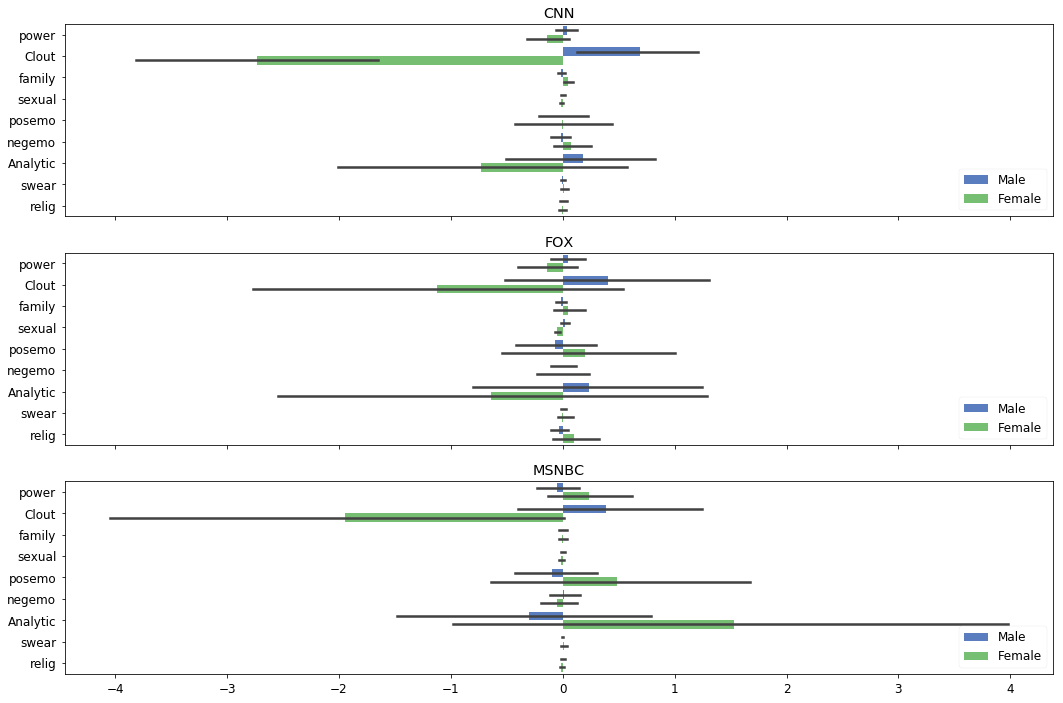

In [187]:
sns.set_context('paper', font_scale = 1.5)

fig, ax = plt.subplots(3, sharex=True)

for i, ch in enumerate(data.channel.unique()):
    ch_data = data[data['channel'] == ch].copy()
    for c in columns:
        model = smf.ols(f"{c} ~ show", data = ch_data).fit()
        resid_power = model.resid
        ch_data[c] = resid_power
    
    melt = ch_data.melt(id_vars=['gender'], value_vars=columns)
    melt.loc[melt['gender'] == 0, 'gender'] = 'Male'
    melt.loc[melt['gender'] == 1, 'gender'] = 'Female'
    sns.barplot(x = 'value', y = 'variable', hue = 'gender', data = melt, palette='muted', ax = ax[i])
    ax[i].set_xlabel("")
    ax[i].set_title(ch)
    ax[i].set_ylabel("")
    ax[i].legend(loc='lower right')
    
    
plt.tight_layout()
# plt.savefig("liwc_graph_1_500.eps", bbox_inches='tight', dpi=500)
plt.show()
    

### Race

In [104]:
data[['channel', 'show', 'speaker', 'race'] + columns].head()

,channel,show,speaker,race,power,Clout,family,sexual,posemo,negemo,Analytic,swear,relig
0,CNN,CNN_Tonight,DON LEMON ( CNN TONIGHT NEWS SHOW HOST),"african,caucasian",5.73,55.06,0.00,0.0,1.27,2.55,93.43,0.0,0.0
1,CNN,CNN_Tonight,KAITLAN COLLINS ( CNN WHITE HOUSE CORRESPONDENT),caucasian,3.38,78.03,0.48,0.0,0.97,0.48,84.52,0.0,0.0
2,CNN,CNN_Tonight,LEMON,caucasian,16.67,95.20,0.00,0.0,0.00,0.00,80.75,0.0,0.0
3,CNN,CNN_Tonight,JACK KINGSTON ( FORMER U.S. REPRESENTATIVE),caucasian,2.94,38.42,0.00,0.0,2.21,2.21,13.36,0.0,0.0
4,CNN,CNN_Tonight,LEMON,caucasian,0.00,99.00,0.00,0.0,0.00,0.00,97.17,0.0,0.0


In [105]:
len(data['speaker'].unique())

2476

#### Most popular characters w/ ethnicity

In [136]:
data.groupby('speaker').agg({'show':len, 'race':lambda x: set(x)}).sort_values(by = 'show', ascending = False).head(30)

,show,race
speaker,,
LEMON,1765,{caucasian}
COOPER,1263,{caucasian}
BURNETT,1231,{caucasian}
HAYES,718,{caucasian}
TAPPER,565,{caucasian}
MELBER,563,"{african,caucasian}"
MACCALLUM,547,{latino}
SCIUTTO,532,{caucasian}
WATTERS,531,{caucasian}


##### Distribution of races

In [137]:
races = sorted(['caucasian', 'african', 'latino', 'eastasian', 'asianindian', 'other'])
races

['african', 'asianindian', 'caucasian', 'eastasian', 'latino', 'other']

In [170]:
d = data.groupby(['channel']).agg({'race':lambda x: Counter(x)}).apply({'race':pd.Series})
d.loc[:, d.columns.get_level_values(1).isin(races)]

race                                             
        african caucasian latino eastasian asianindian other
channel                                                     
CNN       538.0   11378.0  228.0     112.0       133.0   6.0
FOX      1335.0    3109.0  709.0      75.0        43.0  58.0
MSNBC     113.0    2842.0   40.0      16.0         5.0   2.0

##### Statistical tests

First, we check for homeocedasticity between groups. If this test fails (Ho is rejected) then we perform Kruskal-Wallis test, otherwise we do ANOVA.

In [192]:
for ch in data.channel.unique():
    tests = []
    
    for c in columns:
            
        ch_data = data[data.channel == ch]

        # Remove effect of show and gender
        model = smf.ols(f'{c} ~ show + gender', data = ch_data).fit()
        res = model.resid
        
        groups = [res[ch_data.race == r].values for r in races]
        
        # TODO: Update this p to use Holm-Bonferroni correction
        levene_p = stats.levene(*groups).pvalue
        
        if levene_p < alpha:
            # Reject: Groups have different variances
            # Use Krukal-Wallis
            tests.append((c, "KW", stats.mstats.kruskalwallis(*groups)))
            
        else:
            # Cannot reject, assume groups have same variances
            # Use ANOVA
            tests.append((c, "A", stats.f_oneway(*groups)))
        
    ###########################
    # HolmBonferroni correction
    ###########################
    n = len(tests)

    #  order by p-val
    tests = sorted(tests, key = lambda x: x[2].pvalue)
    
    print(f"Channel: {ch}")
    # hb formula for first rank
    rank = 1
    while rank < n + 1:
        hb = alpha / (n - rank + 1)
        if tests[rank - 1][2].pvalue < hb:
            print(f"\t{tests[rank - 1]}")
            rank += 1
        else:
            break
    print()
        
        

Channel: CNN
	('Clout', 'A', F_onewayResult(statistic=4.6325026846963233, pvalue=0.00031686851605833196))

Channel: FOX

Channel: MSNBC
	('Analytic', 'A', F_onewayResult(statistic=4.2431279380937807, pvalue=0.00075827322019862654))



In [193]:
##### TODO: Tukey tests